In [18]:
import os
import glob

import pandas as pd

import fiftyone as fo

from tator_tools.download_media import MediaDownloader
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer
from tator_tools.download_query import QueryDownloader
from tator_tools.yolo_dataset import YOLODataset
from tator_tools.yolo_crop_regions import YOLORegionCropper
from tator_tools.train_model import ModelTrainer
from tator_tools.inference_video import VideoInferencer

from yolo_tiler import YoloTiler, TileConfig

# Download Query from Tator

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 70  # 155

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJtZXRob2QiOiJPUiIsIm9wZXJhdGlvbnMiOlt7ImF0dHJpYnV0ZSI6IiR0eXBlIiwib3BlcmF0aW9uIjoiZXEiLCJpbnZlcnNlIjpmYWxzZSwidmFsdWUiOjUwMH1dfV19"

# Demo for downloading labeled data
frac = 1.0

dataset_name = "AUV_Polygon"
output_dir = "../Data/Labeled_Data"

label_field = "Label"

In [3]:
# Create a downloader for the labeled data
downloader = QueryDownloader(api_token,
                             project_id=project_id,
                             search_string=search_string,
                             frac=frac,
                             output_dir=output_dir,
                             dataset_name=dataset_name,
                             label_field=label_field,
                             download_width=1024)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\search_string.txt


In [4]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 909 objects in query


Processing query: 100%|██████████| 909/909 [00:00<00:00, 26732.73it/s]


NOTE: Found 909 query objects after sampling
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\data.csv
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\data.json
NOTE: Downloading images to e:\tator-tools\Data\Labeled_Data\Marine_Debris\images


NOTE: Images downloaded to e:\tator-tools\Data\Labeled_Data\Marine_Debris\images


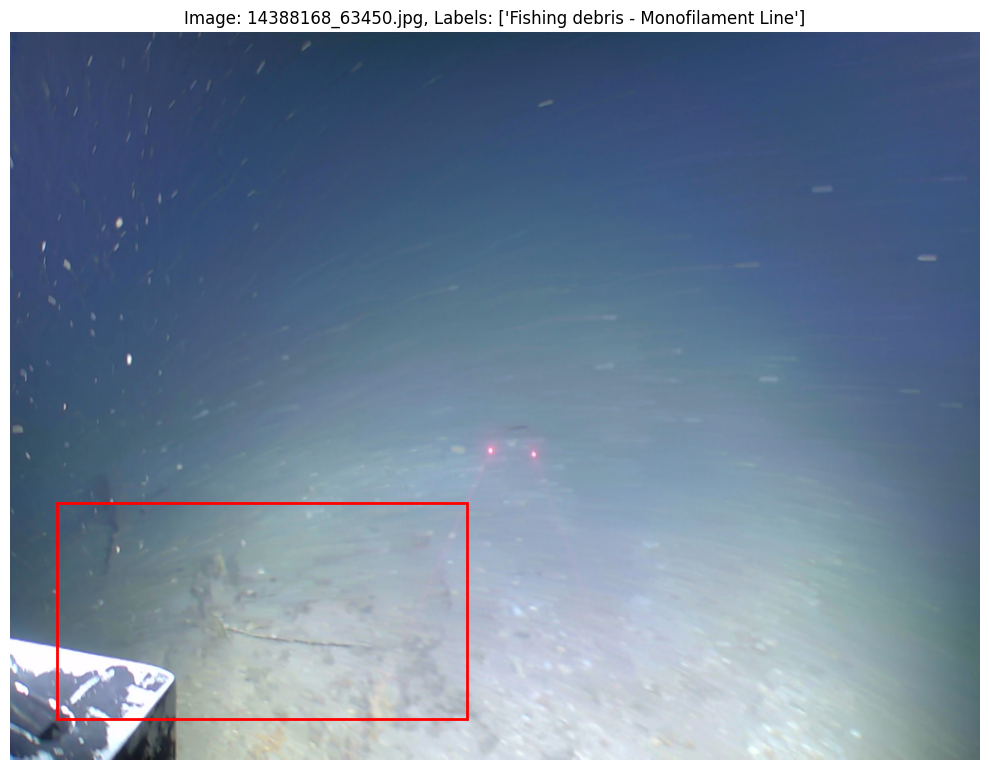

In [5]:
downloader.display_sample()

In [6]:
df = downloader.as_dataframe()  # .as_dict()

# Do some data exploration, filtering as needed
# Example: Drop all rows where x, y, width, or height is NaN
df = df.dropna(subset=["x", "y", "width", "height"])

df.head(3)

,media,frame,image_name,image_path,image_width,image_height,x,y,width,height,polygon,label
0,15171586,0,15171586_0.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.706349,0.217207,0.161620,0.467515,[],Fishing debris - Monofilament Line
1,15171586,0,15171586_0.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.334921,0.545839,0.304923,0.291661,[],Fishing debris - (Other) test
2,4156601,239265,4156601_239265.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.319264,0.388462,0.332298,0.584687,[],"Human (Other) - plastic jug, rope"


# Convert Data into YOLO-formatted Dataset

In [7]:
# Set parameters
output_dir = "../Data/Labeled_Data/AUV_Polygon"
dataset_name = "YOLO_Dataset"

train_ratio = 0.8
test_ratio = 0.1

task = 'detect' # 'detect' or 'segment'

In [8]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task,
    format_class_names=True, 
)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

Processing YOLO dataset with 372 annotations...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dataset split: 255 train, 33 valid, 31 test images


Writing detection labels:   0%|          | 0/319 [00:00<?, ?it/s]

Copying images:   0%|          | 0/319 [00:00<?, ?it/s]

Dataset created at e:\tator-tools\Data\Labeled_Data\Marine_Debris\YOLO_Dataset
Classes: ['Fishingdebris-MonofilamentLine', 'Fishingdebris-(Other)test', 'Human(Other)-plasticjug,rope', 'Line', 'Human(other)–tincan', 'Human(other)-string', 'Anchoringdebris-Anchor', 'Fishingdebris-Line', 'Human(other)-foodcarton', 'Oil&Gas-cable', 'Fishingdebris-line', 'Fishinggear-line', 'RopeLine', 'Anchoringdebris-anchor', 'Anchoringdebris-rope', 'Humandebris-aluminumcan', 'MaybeBottle', 'Humandebris-cable', 'Humandebris-plastic', 'Fishingline', 'anchor', 'beerbottle', 'rope', 'line', 'AnchoringdebrisorFishingdebris', 'FishingdebrisorAnchoringdebris', 'Fishingdebris–monofilamentline', 'Anchoringdebris-Rope', '', 'Vessel-(Other)Test', 'Fishingdebris-TrawlingGear', 'Oil&Gas-(Other)Metalbarrelring', 'Human(other)-(Other)Cable', 'Fishingdebris-(Other)Line', 'Vessel-Firehose', 'Human(other)-Cans', 'Anchoringdebris-Cable', 'Anchoringdebris-Anchors', 'Fishingdebris-LonglineGear', 'Oil&Gas-Pipeline', 'Human(ot

Rendering Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Rendered 10 examples to e:\tator-tools\Data\Labeled_Data\Marine_Debris\YOLO_Dataset\examples


In [10]:
dataset.dataset_dir

'e:\\tator-tools\\Data\\Labeled_Data\\Marine_Debris\\YOLO_Dataset'

# Tile Dataset (Optional)

In [13]:
src = dataset.dataset_dir               # Source YOLO dataset directory
dst = f"{dataset.dataset_dir}_Tiled"    # Output directory for tiled dataset

config = TileConfig(
    # Size of each tile (width, height). Can be:
    # - Single integer for square tiles: slice_wh=640
    # - Tuple for rectangular tiles: slice_wh=(640, 480)
    slice_wh=(1920, 1080),

    # Overlap between adjacent tiles. Can be:
    # - Single float (0-1) for uniform overlap percentage: overlap_wh=0.1
    # - Tuple of floats for different overlap in each dimension: overlap_wh=(0.1, 0.1)
    # - Single integer for pixel overlap: overlap_wh=64
    # - Tuple of integers for different pixel overlaps: overlap_wh=(64, 48)
    overlap_wh=(0.2, 0.2),

    # Input image file extension to process
    input_ext=".jpg",

    # Output image file extension to save (default: same as input_ext)
    output_ext=None,

    # Type of YOLO annotations to process:
    # - "object_detection": Standard YOLO format (class, x, y, width, height)
    # - "instance_segmentation": YOLO segmentation format (class, x1, y1, x2, y2, ...)
    annotation_type="object_detection",

    # Include negative samples (tiles without any instances)
    include_negative_samples=True
)

tiler = YoloTiler(
    source=src,
    target=dst,
    config=config,
    num_viz_samples=15,                     # Number of samples to visualize
    show_processing_status=True,            # Show the progress of the tiling process
)

In [ ]:
tiler.run()

# Crop Regions (Optional)

In [11]:
cropper = YOLORegionCropper(dataset_path=f"{dataset.dataset_dir}\\data.yaml", 
                            output_dir=f"{os.path.dirname(dataset.dataset_dir)}",
                            dataset_name="YOLO_Dataset_Cropped",
                            format_class_names=True)

In [12]:
# Process the dataset to create classification crops
cropper.process_dataset()

NOTE: Loading dataset...
NOTE: Converting dataset...
Added 255 images from train dataset
Added 33 images from validation dataset
Added 31 images from test dataset


SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


NOTE: Loaded dataset - 372 detections found


Creating crops: 100%|██████████| 319/319 [00:00<00:00, 377.94it/s]

Created 372 crops from 319 images
NOTE: Writing classification dataset YAML...
Classification dataset YAML written to e:\tator-tools\Data\Labeled_Data\Marine_Debris/YOLO_Dataset_Cropped/data.yaml
Class distribution:
  Fishingdebris-MonofilamentLine: train=61, val=21, test=11
  Fishingdebris-(Other)test: train=1, val=0, test=0
  Human(Other)-plasticjug,rope: train=1, val=1, test=0
  Line: train=5, val=1, test=0
  Human(other)–tincan: train=1, val=1, test=0
  Human(other)-string: train=1, val=1, test=0
  Anchoringdebris-Anchor: train=3, val=1, test=0
  Fishingdebris-Line: train=11, val=1, test=3
  Human(other)-foodcarton: train=0, val=2, test=0
  Oil&Gas-cable: train=9, val=1, test=1
  Fishingdebris-line: train=11, val=1, test=3
  Fishinggear-line: train=1, val=1, test=0
  RopeLine: train=1, val=0, test=0
  Anchoringdebris-anchor: train=3, val=1, test=0
  Anchoringdebris-rope: train=27, val=9, test=2
  Humandebris-aluminumcan: train=3, val=1, test=0
  MaybeBottle: train=1, val=1, test=0


# Train a YOLO Model

In [15]:
dir_ = "E:\\tator-tools\\Data\\Labeled_Data\\MR_Downward_Facing_Imagery\\YOLODataset_Detection"

# Initialize the trainer with the required parameters
trainer = ModelTrainer(
    training_data=f"{dir_}\\data.yaml",
    weights="yolov8m.pt",
    output_dir=f"{dir_}\\Training",
    name="yolov8m",
    task='detect',
    epochs=50,
    half=True,
    imgsz=640,
    single_cls=False,
    plots=True,
    batch=0.5,
)

In [ ]:
# Train the model
trainer.train_model()

In [ ]:
# Evaluate on the model (if test data is available)
trainer.evaluate_model()

# Inference on Video

In [19]:
# Set parameters
model_weights = "E:\\tator-tools\\Data\\Labeled_Data\\AUV_Polygons\\YOLODataset_Detection_Tiled\\Training\\AUV_Polygons_Detection\\weights\\best.pt"

video_path = "E:\\tator-tools\\Data\\Raw_Videos\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4"
output_dir = "E:\\tator-tools\\Data\\Inference_Results"


In [ ]:
inferencer = VideoInferencer(
    weights_path=model_weights,
    model_type='yolo',
    video_path=video_path,
    output_dir=output_dir,
    start_at=1000,
    end_at=2000,
    conf=0.5,
    iou=0.3,
    track=False,
    segment=False,
    sahi=False,
    show=True
)

In [ ]:
inferencer.inference()